In [91]:
# Работа с данными
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import phik
import missingno as msno

# Разбиение на train и test, кросс-валидацияб подбор гиперпараметров
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score

# Препроцессинг и пайплайны
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbLearnPipeline
from imblearn.over_sampling import SMOTE


# Модели классификации
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Метрики и оценки
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, f1_score, average_precision_score, ConfusionMatrixDisplay
import shap

# Настройки
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
shap.initjs()
print("Все бибилотеки успешно подключены ☑️")

Все бибилотеки успешно подключены ☑️


##### Загрузка и обзор датасета

In [6]:
credit_data = pd.read_csv(r"E:\projects\Проекты по DS\data\creditcard.csv")
print(credit_data.shape)

(284807, 31)


In [7]:
print(credit_data.head(5))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20 

In [8]:
print(credit_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
print(credit_data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.384974e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.021879e-15  1.494498e-15 -5.620335e-16  1.149614e-16 -2.414189e-15   
std    1.380247e+00  1.332271e+00  1.23709

### Разведывательеный анализ данных (EDA)  

посмотрим на распределение таргета и найдём центральные тенденции

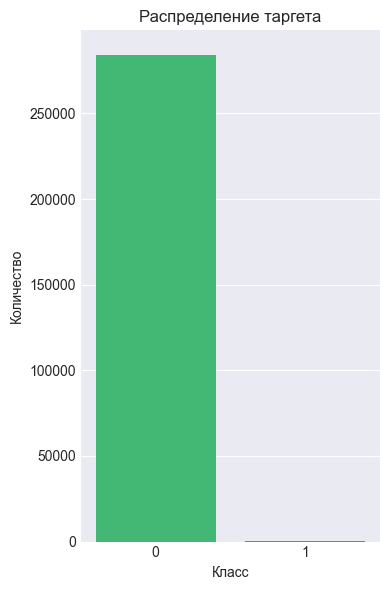

In [9]:
plt.figure(figsize=(4, 6))
sns.countplot(data=credit_data, x='Class', palette=['#2ecc71', '#e74c3c'])
plt.title('Распределение таргета')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.tight_layout()
plt.legend()
plt.show()

In [10]:
fraud_count = credit_data['Class'].value_counts()
fraud_percentage = credit_data['Class'].value_counts(normalize=True) * 100

print(f'Законные трагзакции(0): {fraud_count[0]} ({fraud_percentage[0]})')
print(f'Мошеннические транзакции(2): {fraud_count[1]} ({fraud_percentage[1]})')

Законные трагзакции(0): 284315 (99.82725143693798)
Мошеннические транзакции(2): 492 (0.1727485630620034)


Так как есть большой дисбаланс классов, то для корректного обучения модели необходимы специальные процедуры (SMOTE)

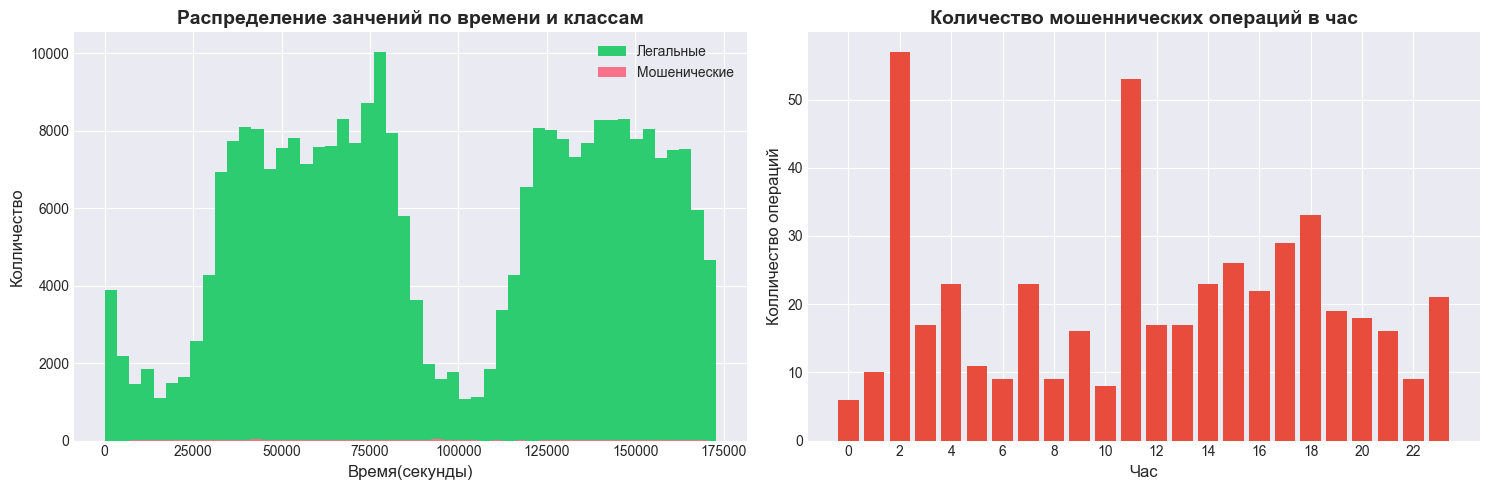

In [11]:
# Распределение по времени

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(credit_data[credit_data['Class'] == 0]['Time'], bins=50, label='Легальные', color="#2ecc71")
axes[0].hist(credit_data[credit_data['Class'] == 1]['Time'], bins=50, label='Мошенические')
axes[0].set_title('Распределение занчений по времени и классам', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Время(секунды)', fontsize=12)
axes[0].set_ylabel('Колличество', fontsize=12)
axes[0].legend()

credit_data['Hour'] = ((credit_data['Time'] % 86400) / 3600).astype(int)
fraud_by_hour = credit_data[credit_data['Class'] == 1].groupby('Hour').size()
axes[1].bar(fraud_by_hour.index, fraud_by_hour.values, color='#e74c3c', width=0.8)
axes[1].set_title('Количество мошеннических операций в час', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Час', fontsize=12)
axes[1].set_ylabel('Колличество операций', fontsize=12)
axes[1].set_xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

#### Корреляционный анализ

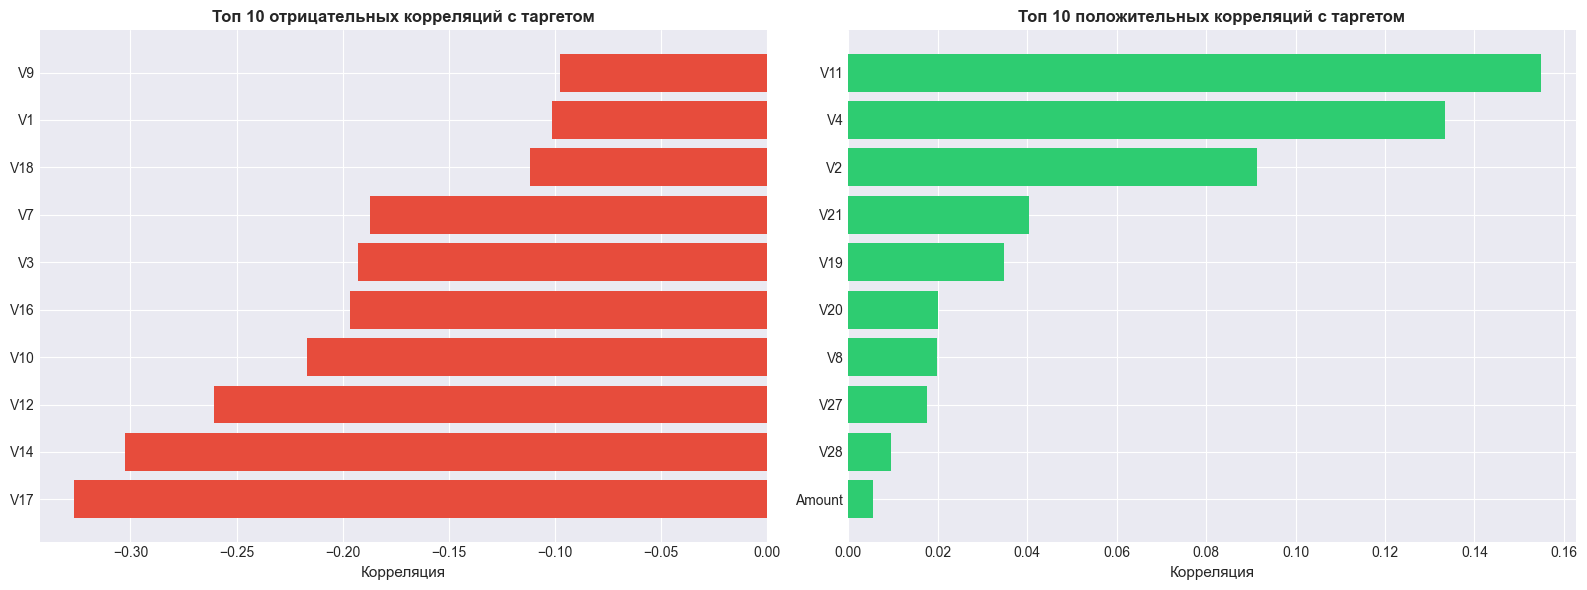

In [11]:
correlations = credit_data.corr()['Class'].drop('Class').sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# топ 10 отрицательных корреляций с таргетом
top_ten_negative = correlations.head(10)
axes[0].barh(top_ten_negative.index, top_ten_negative.values, color='#e74c3c')
axes[0].set_title('Топ 10 отрицательных корреляций с таргетом', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Корреляция', fontsize=11)

# топ 10 положительных корреляций с таргетом
top_ten_positive = correlations.tail(10)
axes[1].barh(top_ten_positive.index, top_ten_positive.values, color='#2ecc71')
axes[1].set_title('Топ 10 положительных корреляций с таргетом', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Корреляция', fontsize=11)

plt.tight_layout()
plt.show()

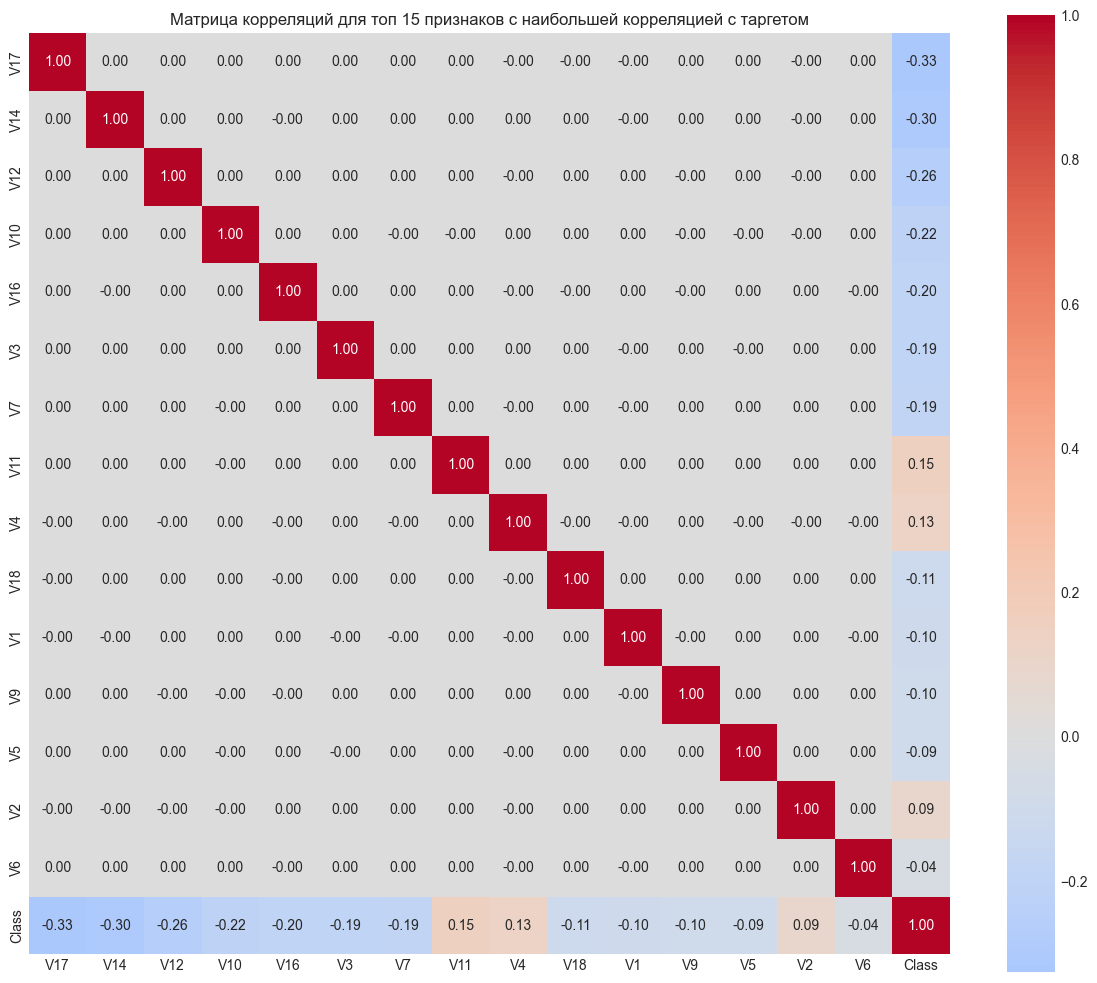

In [38]:
top_features = correlations.abs().sort_values(ascending=False).head(15).index.tolist()
top_features.append('Class')
plt.figure(figsize=(12, 10))

sns.heatmap(credit_data[top_features].corr(), fmt=".2f", center=0, cmap='coolwarm', annot=True, square=True)
plt.title('Матрица корреляций для топ 15 признаков с наибольшей корреляцией с таргетом')
plt.tight_layout()
plt.show()

In [39]:
data_preprosessed = credit_data[top_features].copy()

# Удаляем столбец 'Hour' если он есть в top_features
if 'Hour' in data_preprosessed.columns:
    data_preprosessed = data_preprosessed.drop('Hour', axis=1)

X = data_preprosessed.drop('Class', axis=1)
y = data_preprosessed['Class']

print(f"Признаки: {X.shape}")
print(f"Таргет: {y.shape}")
print(f"\nПризнаки: {X.columns.tolist()}")

Признаки: (284807, 15)
Таргет: (284807,)

Признаки: ['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18', 'V1', 'V9', 'V5', 'V2', 'V6']


### Подготовка данных и обучение моделей

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Так как все признаки выбранные для обучения были получены с помощью PCA и уже являются стандартизированными, то дополнительных скейлеров не потребуется

In [ ]:
def find_preprosessing_score(model):
    
    best_params = model.best_params_
    best_score = model.best_score_
    
    # Получаем индекс лучшей модели
    best_index = model.best_index_
    results_df = pd.DataFrame(model.cv_results_)
    
    mean_fit_time = results_df['mean_fit_time'].iloc[best_index]
    mean_score_time = results_df['mean_score_time'].iloc[best_index]

    model_stats = {
        'Лучшие параметры': best_params,
        'Время обучения (сек)': round(mean_fit_time, 3),
        'Время предсказания (сек)': round(mean_score_time, 3),
        'Average Precision': round(best_score, 3)
    }

    for key, value in model_stats.items():
        print(f'{key}: {value}')
    return model_stats

Первой моделью будет логистическая регрессия с class_weight = balanced

In [42]:
lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
param_grid = {
    'C': [0.01, 0.1, 1, 10]
}

lr_search = GridSearchCV(
    lr,
    param_grid,
    cv=cv,
    scoring='average_precision'
)

lr_search.fit(X_train, y_train)
lr_stats = find_preprosessing_score(lr_search)

Лучшие параметры: {'C': 10}
Время обучения (сек): 0.22
Время предсказания (сек): 0.008
Average Precision: 0.747


Теперь обучим модель решаюшего дерева со SMOTE для коррекции дисбаланса классов

In [ ]:
dtree_pipe = ImbLearnPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('dtree', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

dtree_param_grid = {
    'dtree__max_depth': np.arange(3, 10),
    'dtree__min_samples_split': [5, 10, 20],
    'dtree__min_samples_leaf': [1, 5, 10],
    'dtree__max_features': ['sqrt', 'log2']
}

In [ ]:
dtree_search = GridSearchCV(
    dtree_pipe,
    dtree_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

dtree_search.fit(X_train, y_train)

dtree_stats = find_preprosessing_score(dtree_search)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Лучшие параметры: {'dtree__max_depth': np.int64(9), 'dtree__max_features': 'sqrt', 'dtree__min_samples_leaf': 10, 'dtree__min_samples_split': 5}
Время обучения (сек): 3.796
Время предсказания (сек): 0.017
Average Precision: 0.646


Теперь обучим случайный лес с class_weight = 'balanced'

In [23]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 5]
}

In [24]:
rf_search = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    rf_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)

rf_stats = find_preprosessing_score(rf_search)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Время обучения (сек): 193.732
Время предсказания (сек): 0.532
Average Precision: 0.838
Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Время обучения (сек): 193.732
Время предсказания (сек): 0.532
Average Precision: 0.838



Теперь обучим LightGBM (градиентный бустинг)


In [51]:
lgbm_param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [5, 7, 10]
}

lgbm_search = GridSearchCV(
    LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE, verbose=-1),
    lgbm_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

lgbm_search.fit(X_train, y_train)
lgbm_stats = find_preprosessing_score(lgbm_search)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры: {'max_depth': 10, 'n_estimators': 500}
Время обучения (сек): 26.902
Время предсказания (сек): 0.489
Average Precision: 0.822


In [52]:

# === ТАБЛИЦА БЕЗ ПАРАМЕТРОВ ===
# Берем только нужные ключи из словарей (исключаем первый ключ с параметрами)

models = ['Логистическая регрессия', 'Дерево решений', 'Случайный лес', 'LightGBM']
stats_list = [lr_stats, dtree_stats, rf_stats, lgbm_stats]

# Получаем ключи (кроме первого - параметры)
keys = list(lr_stats.keys())[1:]

# Создаем таблицу без параметров
table_data = {}
for key in keys:
    table_data[key] = [stats[key] for stats in stats_list]

df_results = pd.DataFrame(table_data, index=models)
print(df_results)


                         Время обучения (сек)  Время предсказания (сек)  \
Логистическая регрессия                 0.217                     0.008   
Дерево решений                          3.675                     0.018   
Случайный лес                         256.888                     0.845   
LightGBM                               26.902                     0.489   

                         Average Precision  
Логистическая регрессия              0.747  
Дерево решений                       0.646  
Случайный лес                        0.838  
LightGBM                             0.822  


Итоговою моделью был выбран LightGBM, так как эта модель является второй по точности, но при этом обучается в 10 раз быстрее чем самая точная модель

In [93]:
best_model = lgbm_search.best_estimator_
print(lgbm_search.best_params_)

{'max_depth': 10, 'n_estimators': 500}


Проверим итоговую модель на тестовых данных и вычислим занчения некоторых метрик

In [58]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

f1 = f1_score(y_pred=y_pred, y_true=y_test)
roc_auc = roc_auc_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred)

print(f'F1-score: {round(f1, 3)}\nROC-AUC: {round(roc_auc, 3)}\nPR-AUC: {round(pr_auc, 3)}')


F1-score: 0.837
ROC-AUC: 0.918
PR-AUC: 0.7


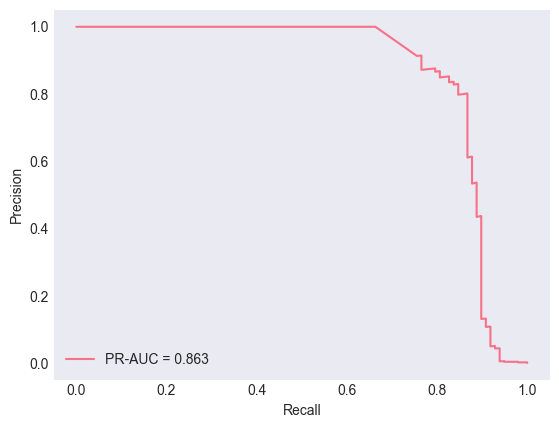

In [59]:
y_scores = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

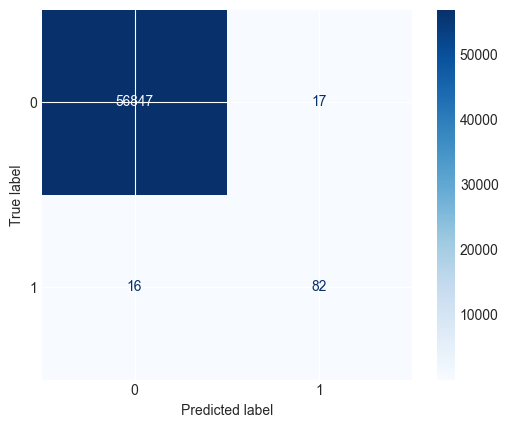

In [63]:
threshold = 0.3  # пример — не 0.5!
y_pred = (y_scores >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.show()

In [75]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

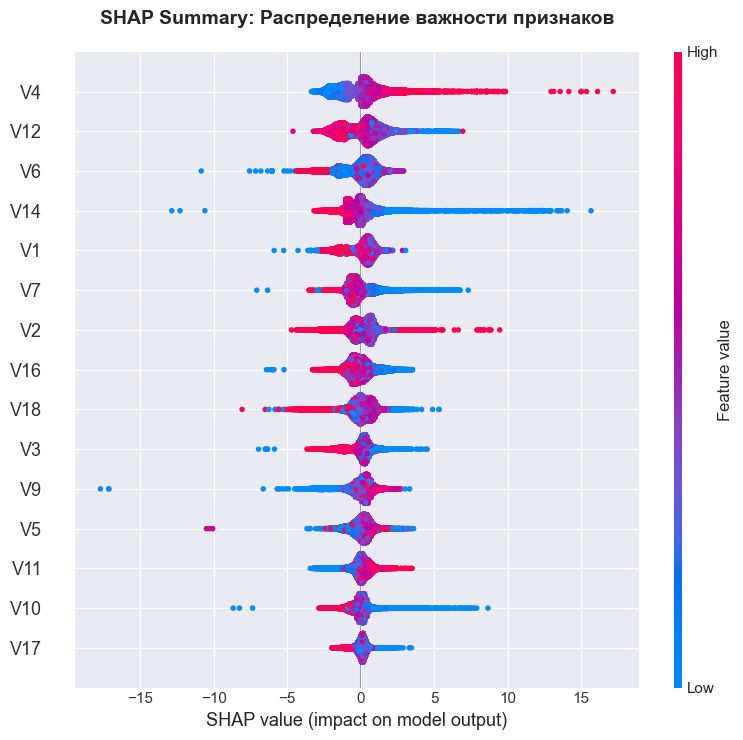

In [76]:
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Summary: Распределение важности признаков', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


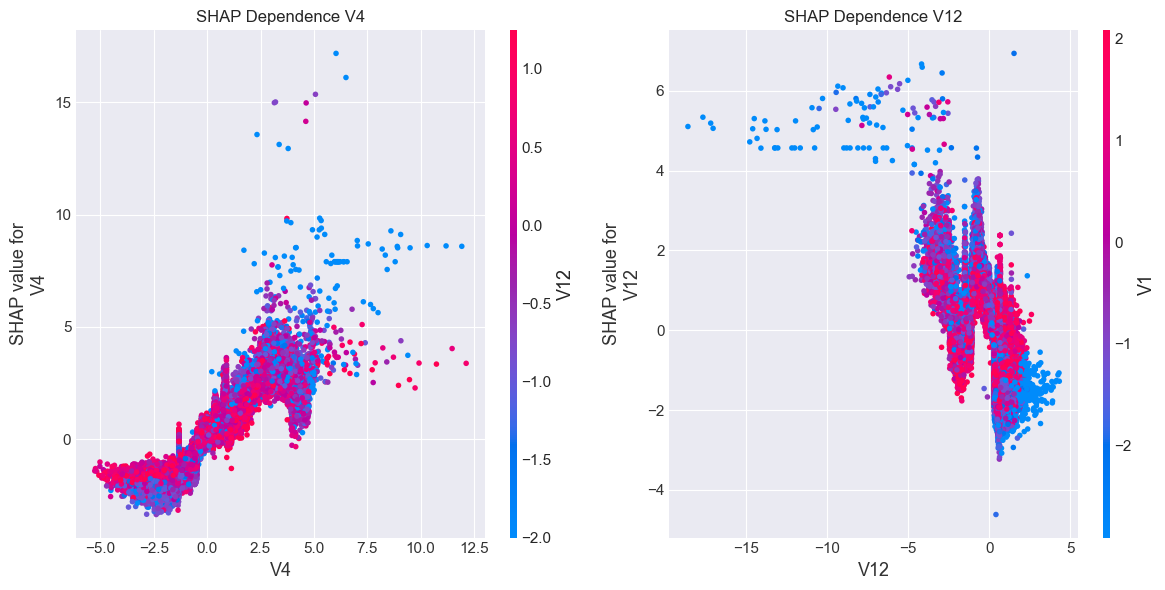

In [83]:

# shap_values может быть списком (по классам) — возьмём вклад положительного класса, если нужно
sv = shap_values[1] if isinstance(shap_values, list) else shap_values

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Dependence для V4
shap.dependence_plot('V4', sv, X_test, ax=axes[0], show=False)
axes[0].set_title('SHAP Dependence V4')

# Dependence для V12
shap.dependence_plot('V12', sv, X_test, ax=axes[1], show=False)
axes[1].set_title('SHAP Dependence V12')

plt.tight_layout()
plt.show()